In [309]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [310]:
import pathlib
import re

import copy

import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_expand_data=False)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',palette='bright',style='ticks')

import tqdm

from scipy.stats import norm

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_formats = ['svg']

In [311]:
from AFL.automation import prepare
from AFL.automation.APIServer import DummyDriver
from AFL.automation.shared.units import units,is_concentration,is_volume,is_mass
from AFL.agent.AgentClient import AgentClient
from AFL.agent import xarray_extensions, GaussianProcess
from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction
from AFL.automation.APIServer.Client import Client

In [312]:
from SAS_model_fit_driver import SAS_model_fit, sas_wrapper
import sasmodels

## Server instantiation

In [313]:
path = '//mnt/c/Users/drs18/Downloads/230530_AL_manifest-P188_2D_MultiModal_UCB_noThomp_FixedP188.nc'

In [335]:
netcdf_path = path
model_ds = xr.load_dataset(netcdf_path)

sasfit_url = 'localhost:5058'
sasfit_client = Client(sasfit_url.split(':')[0],port=sasfit_url.split(':')[1])
sasfit_client.login('SampleServer_SASfit_Client')
sasfit_client.debug(False)
sasfit_client.set_config(
    filepath='/Users/drs18/Documents/multimodal-dev/SAS_fitting_agent_dev/',
    save_path='/Users/drs18/Documents/multimodal-dev/SAS_fitting_agent_dev/',
    q_range = (model_ds.q.min().values.tolist(), model_ds.q.max().values.tolist()),
    model_inputs = [{
        'name':'power_law_1',
        'sasmodel':'power_law',
        'fit_params':{
            'power':{
                'value':4,
                'bounds':(3,4.5)
            },
            'background':{
                'value':1e-4,
                'bounds':(1e-10,1e2)
            },
            'scale':{
                'value':1e0,
                'bounds':(1e-6,1e4)
            }
        }
    }]
)


'QD-bdc4b4ef-fe4b-4f99-8aed-2a7ace4a248b'

In [202]:
sasfit_client.enqueue(task_name='construct_models')

UUID('be656c2a-db9b-4003-9de6-1aff25ea0f4e')

In [203]:
config = sasfit_client.get_config('all',interactive=True)

In [204]:
dummy_model = config['return_val']['model_inputs'][0]
add_model = dummy_model
# print(add_model)
add_model['name'] = 'power_law_2'
add_model['fit_params']['power'] = {'value':2, 'bounds':[1,3]}
sasfit_client.enqueue(task_name='add_model',model_dict=[add_model])

add_model['name'] = 'power_law_3'
add_model['fit_params']['power'] = {'value':800, 'bounds':[100,1000]}
sasfit_client.enqueue(task_name='add_model',model_dict=[add_model])


UUID('e2a1a376-f508-467a-8872-9ce01adcc4f0')

In [240]:
sasfit_client.enqueue(task_name='remove_model',name='power_law_3')

UUID('9473a90e-6b59-4595-a4e2-459e00e35672')

## Test on real data with fitting

In [336]:
data = []
Is = []
dIs = []
for idx in range(len(model_ds.SAS)):
    
    q = model_ds.q.values#[:-25]
    I = model_ds.SAS[idx].values#[:-25]
    dI = 0.1 * I
    Is.append(I.tolist())
    dIs.append(dI.tolist())
# data = sasmodels.data.Data1D(x=q,y=I,dy=dI) 
initial_models = [
    {'name':"polymer_micelle_1",
     'sasmodel':'polymer_micelle',
     'fit_params':{
            "scale"       : {'value':2*np.average(Is), 'bounds':(1e-1,1e4)},
            "background"  : {'value':50,       'bounds':(1e-1,1e4)},
            "radius_core" : {'value':40,       'bounds':(1e-1,1e4)},
            "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
            "sld_core"    : {'value':5.45,     'bounds':None},
            "sld_corona"  : {'value':5.15,     'bounds':None},
            "sld_solvent" : {'value':6.36,     'bounds':None},
     }
    },
    {'name':"small_sphere_1",
     'sasmodel':'sphere',
     'fit_params':{
            "scale"       : {'value':np.average(Is),   'bounds':(1e-1,1e4)},
            "background"  : {'value':20,       'bounds':(1e1,1e2)},
            "radius"      : {'value':50,       'bounds':(1e-1,1e3)},
            "radius_pd"   : {'value':0.15,       'bounds':(0.02,0.5)},
            "radius_pd_type": {'value':'gaussian','bounds':None},
            "radius_pd_n": {'value':15,'bounds':None},
            "sld"         : {'value':5.45,     'bounds':None},
            "sld_solvent" : {'value':6.36,     'bounds':None},
        }
    },
    {'name':"poly_gauss_coil_1",
     'sasmodel':'poly_gauss_coil',
     'fit_params':{
            "i_zero"      : {'value':np.average(Is),   'bounds':(1e-1,1e4)},
            "background"  : {'value':40,       'bounds':(1e-1,1e4)},
            "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
            # "polydispersity": {'value':1,       'bounds':(0.5,2)}
        }
    }
]

In [337]:
sasfit_client.set_config(model_inputs=initial_models)

'QD-ef48f68b-370e-4aa0-b183-b8f6fce87bd5'

In [338]:
sasfit_client.enqueue(task_name='construct_models')

'QD-04dd7274-846d-4aa8-8049-05d5ef9e5f62'

In [339]:
sasfit_client.enqueue(task_name='print_model_pointer')

'QD-3ca746af-63b0-43a8-a478-7ad2978290c6'

### batch fitting

In [340]:
fit_method={'method':'lm',
            'steps':12345,
            'ftol': 1.5e-6,
            'xtol': 1.5e-6,
            'verbose':True
           }
data_ID = [f'data_{str(idx+1).zfill(3)}' for idx in range(3*len(model_ds.SAS))]
# sasfit_client.enqueue(task_name="fit_models",data=data,
#                       data_ID=data_ID,
#                      fit_method=fit_method)
sasfit_client.enqueue(
    task_name='fit_models',
    q=q.tolist(), I=Is, dI=dIs,
    fit_method=fit_method
)

'QD-e17e2384-7646-465a-aa59-bad04f5b386a'

In [344]:
report_json = sasfit_client.enqueue(task_name='build_report',interactive=True)['return_val']
len(list(report_json['best_fits']['model_params']))

33

In [277]:
report_json = sasfit_client.get_driver_object('report')
report_json['best_fits']['model_idx']

[0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2]

{'fit_method': {'method': 'lm',
  'steps': 12345,
  'ftol': 1.5e-06,
  'xtol': 1.5e-06,
  'verbose': True},
 'model_inputs': [{'name': 'polymer_micelle_1',
   'sasmodel': 'polymer_micelle',
   'fit_params': {'scale': {'value': 605.865966796875,
     'bounds': [0.1, 10000.0]},
    'background': {'value': 50, 'bounds': [0.1, 10000.0]},
    'radius_core': {'value': 40, 'bounds': [0.1, 10000.0]},
    'rg': {'value': 60, 'bounds': [0.1, 10000.0]},
    'sld_core': {'value': 5.45, 'bounds': None},
    'sld_corona': {'value': 5.15, 'bounds': None},
    'sld_solvent': {'value': 6.36, 'bounds': None}}},
  {'name': 'small_sphere_1',
   'sasmodel': 'sphere',
   'fit_params': {'scale': {'value': 302.9329833984375,
     'bounds': [0.1, 10000.0]},
    'background': {'value': 20, 'bounds': [10.0, 100.0]},
    'radius': {'value': 50, 'bounds': [0.1, 1000.0]},
    'radius_pd': {'value': 0.15, 'bounds': [0.02, 0.5]},
    'radius_pd_type': {'value': 'gaussian', 'bounds': None},
    'radius_pd_n': {'value'

In [345]:
report_json['model_fits'][0]

[{'chisq': 0.10901291054753041,
  'name': 'polymer_micelle_1',
  'output_fit_params': {'background': {'error': 0.4066154230293928,
    'value': 35.60986504881692},
   'radius_core': {'error': 0.4835316041887588, 'value': 37.480011152157466},
   'rg': {'error': 0.7911959162181836, 'value': 18.66627935418734},
   'scale': {'error': 30.75853845506097, 'value': 1294.2859936281984},
   'sld_core': {'error': None, 'value': 5.45},
   'sld_corona': {'error': None, 'value': 5.15},
   'sld_solvent': {'error': None, 'value': 6.36}},
  'sasmodel': 'polymer_micelle'},
 {'chisq': 0.46635372816789317,
  'name': 'small_sphere_1',
  'output_fit_params': {'background': {'error': 0.24358973857785687,
    'value': 41.93350782760099},
   'radius': {'error': 3.7913807395903545, 'value': 31.40846966465097},
   'radius_pd': {'error': 0.10622041204783757, 'value': 0.5},
   'radius_pd_n': {'error': None, 'value': 15},
   'radius_pd_type': {'error': None, 'value': 'gaussian'},
   'scale': {'error': 0.28181083626

### extract the fit values and uncertainties

In [304]:
Y = []
for i, m_id in enumerate(report_json['best_fits']['model_idx']):
    if m_id == 0:
        target = report_json['model_fits'][i][0]['output_fit_params']['radius_core']['value']
        err = report_json['model_fits'][i][0]['output_fit_params']['radius_core']['error']
        Y.append([target,err])
    else:
        Y.append(None)
X_train = []
Y_train = []
for x, y in zip(X,Y):
    
    if y != None:
        X_train.append(x)
        Y_train.append(y)
np.array(X_train),np.array(Y_train)
print(np.hstack((np.array(X_train))
np.save('regressor_data.npy',np.hstack((np.array(X_train),np.array(Y_train))))

[[ 5.          5.         37.48001115  0.4835316 ]
 [14.69387755  2.75510204 37.57557494  0.54453417]
 [ 9.48979592  3.06122449 29.18666852  0.61645952]
 [ 0.          7.11201143 38.96323608  0.43538035]
 [12.85714286  2.44897959 19.07644655  0.62114634]
 [11.32653061  2.44897959 13.23804789  1.5408213 ]
 [ 8.57142857  3.06122449 16.19273286  0.76890013]
 [ 8.26530612  4.59183673 36.8361137   0.63342369]
 [ 8.26530612  4.59183673 38.50040851  0.49860252]
 [14.69387755  2.14285714 30.74869014  0.60668012]
 [ 7.95918367  3.36734694 15.13831629  0.88665459]
 [ 7.04081633  3.36734694 18.57214445  0.60691404]
 [ 6.12244898  3.67346939 16.73247896  0.6607839 ]]


In [306]:
report_json

{'best_fits': {'lowest_chisq': [0.10901291054753041,
   0.36004023494342136,
   0.21137123502823982,
   0.10119331778380483,
   0.09637957422724898,
   0.09859662721886346,
   0.04540412677059357,
   0.09378359555405485,
   0.26180965236746456,
   0.07332627619158576,
   0.14911323203907703,
   0.1278234739607258,
   0.3031391002014563,
   0.07601280578909,
   0.06890239665274604,
   0.09769010457151656,
   0.0972592368677008,
   0.05412723363549471,
   0.06200199966145735,
   0.044657506809508925,
   0.08015696381072583,
   0.18883658419180893,
   0.11384911220746385,
   0.11083527163170204,
   0.1487101258527851,
   0.10736126402433908,
   0.1571073804102202,
   0.09284817643662265,
   0.048305295866796764,
   0.05809428157672986,
   0.08637762831895643,
   0.17109478186568153,
   0.1569843711323423],
  'model_idx': [0,
   1,
   1,
   2,
   2,
   2,
   2,
   2,
   1,
   0,
   2,
   0,
   0,
   2,
   2,
   0,
   2,
   0,
   2,
   0,
   0,
   0,
   2,
   2,
   0,
   2,
   2,
   2,
   0

## Report pull and reconstituting

Human readable analysis and reporting


background 35.60986504881692
radius_core 37.480011152157466
rg 18.66627935418734
scale 1294.2859936281984
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 41.93350782760099
radius 31.40846966465097
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 13.980580012904795
sld 5.45
sld_solvent 6.36
background 33.12830242182398
i_zero 1297.4045516105546
rg 121.10227885227921


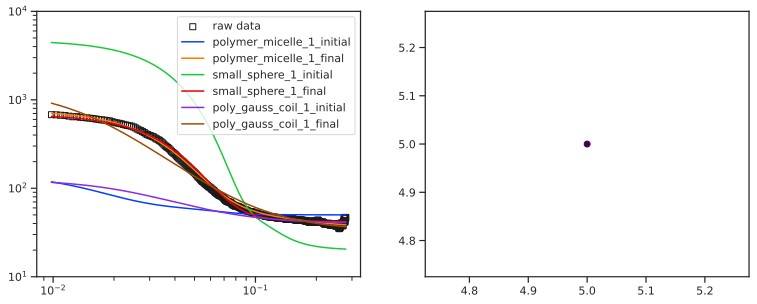


background 24.23259307980526
radius_core 54.479561176189094
rg 134.6728994003254
scale 10000.0
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 24.89005266334118
radius 46.24217502627511
radius_pd 0.30425226515199455
radius_pd_n 15
radius_pd_type gaussian
scale 23.11394048313657
sld 5.45
sld_solvent 6.36
background 18.143885823188256
i_zero 10000.0
rg 369.4273820675963


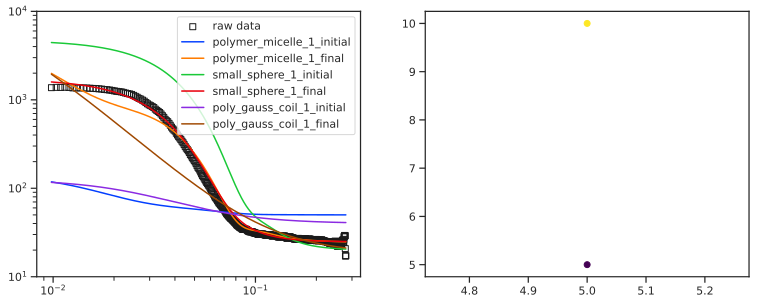


background 33.974453770835716
radius_core 109.88442702986747
rg 128.13458439287712
scale 10000.0
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 35.858860170273715
radius 122.89512798106459
radius_pd 0.3930165589442932
radius_pd_n 15
radius_pd_type gaussian
scale 7.37944665274003
sld 5.45
sld_solvent 6.36
background 32.3805386573941
i_zero 10000.0
rg 673.5445722933003


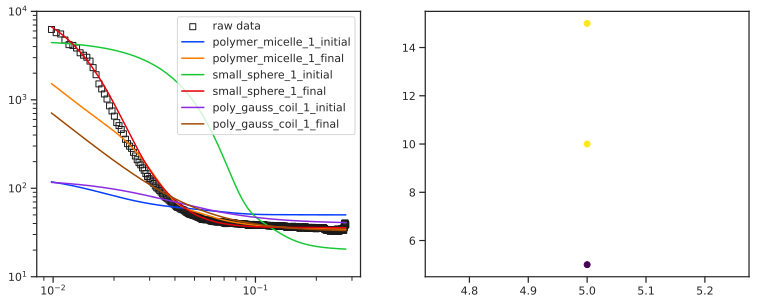


background 51.44635390535807
radius_core 11.420373015808808
rg 17.155726904570038
scale 138.57509996121516
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 55.51561780112207
radius 16.228280915065543
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 9.578257100006844
sld 5.45
sld_solvent 6.36
background 51.085365510227795
i_zero 78.83806445701646
rg 34.27096807969264


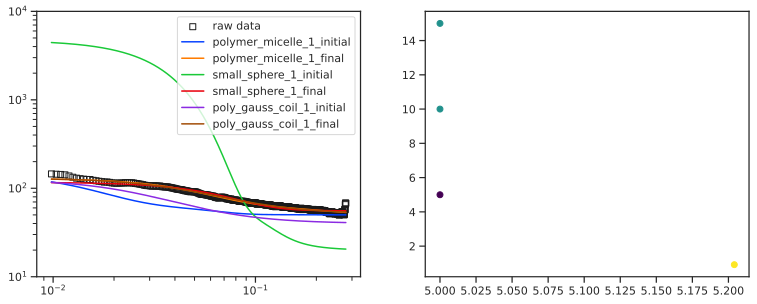


background 49.61844313362509
radius_core 10.962375275462353
rg 16.54437000240868
scale 149.9195837935623
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 54.3446790130966
radius 15.825448633072895
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 11.188282778928274
sld 5.45
sld_solvent 6.36
background 49.40144374085718
i_zero 85.34602296549126
rg 33.25127168373325


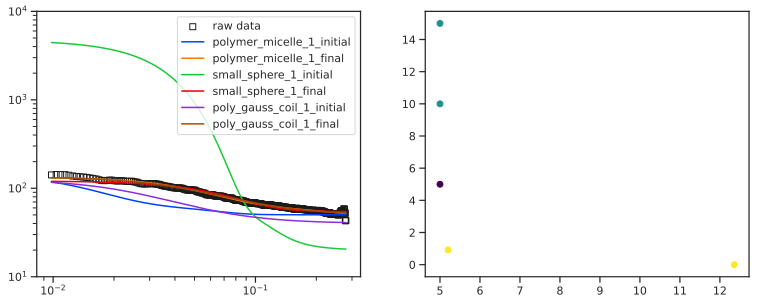


background 51.01874230058377
radius_core 10.622367846163751
rg 16.295679720406664
scale 124.86243292105075
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 55.14531785287992
radius 15.555499804565686
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 9.802231032581236
sld 5.45
sld_solvent 6.36
background 50.703597286602175
i_zero 69.93230062081437
rg 31.681635896818563


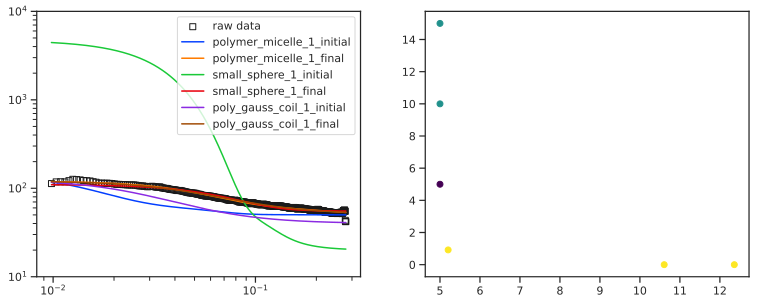


background 50.7048383159141
radius_core 10.810128491378688
rg 16.236987551140835
scale 137.5278763373658
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 55.144085220886396
radius 15.689774610005275
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 10.602653401934068
sld 5.45
sld_solvent 6.36
background 50.44470143813325
i_zero 78.2919906864454
rg 32.589615514676375


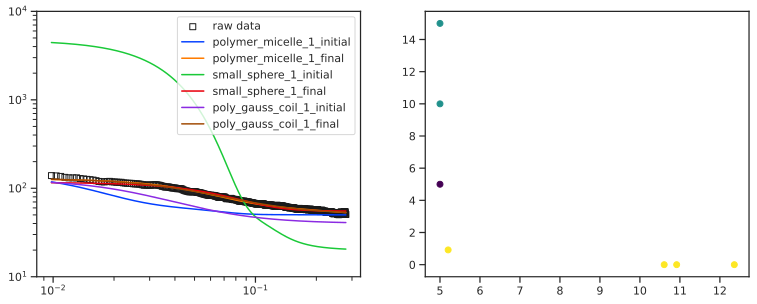


background 51.71165553810817
radius_core 11.670777350077596
rg 18.1866908917986
scale 135.64900828486535
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 55.49422897099871
radius 16.44590756509281
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 8.78503604966029
sld 5.45
sld_solvent 6.36
background 51.395149857257074
i_zero 75.97955996764165
rg 35.20469800507089


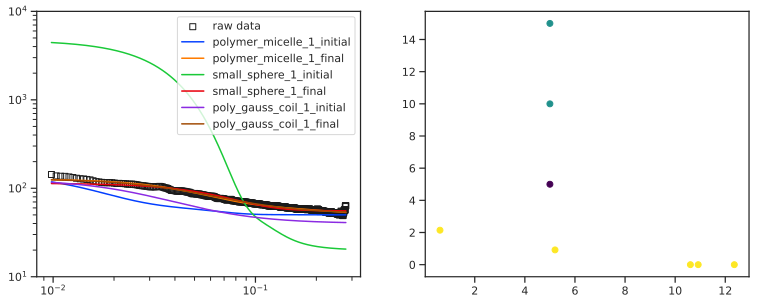


background 26.739496117286645
radius_core 57.17372847653945
rg 124.4972532959684
scale 10000.0
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 27.711726885355752
radius 50.13078156124796
radius_pd 0.2819400317395544
radius_pd_n 15
radius_pd_type gaussian
scale 20.64363815367882
sld 5.45
sld_solvent 6.36
background 20.908203995688222
i_zero 10000.0
rg 380.25962909426437


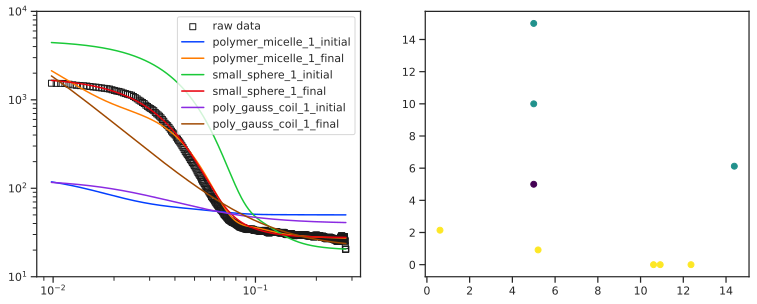


background 40.36049895186008
radius_core 37.57557494206858
rg 18.459354872146854
scale 1133.5249820825172
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 46.105980256392016
radius 31.600638736995645
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 12.087494099943694
sld 5.45
sld_solvent 6.36
background 37.64366536171479
i_zero 1090.4966764388892
rg 115.30770272578485


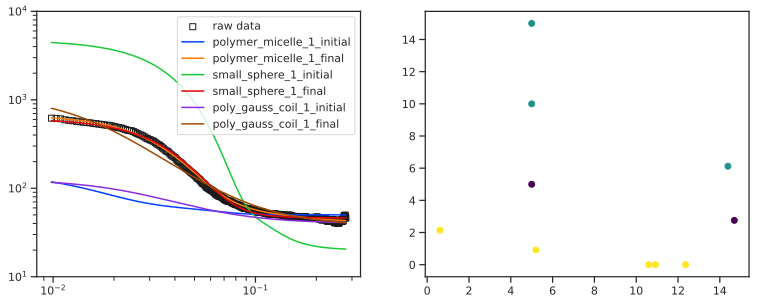


background 47.40124203178638
radius_core 10.444989211263144
rg 16.435566591662212
scale 158.82780601470122
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 52.72734476528274
radius 15.315696048752319
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 12.770494505461016
sld 5.45
sld_solvent 6.36
background 47.36558898268245
i_zero 88.43320069316846
rg 31.916373607364278


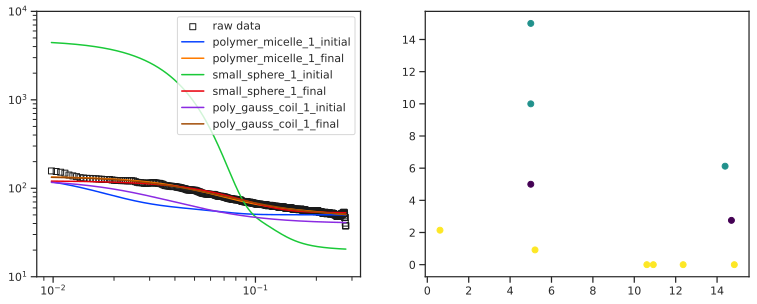


background 52.164222874292065
radius_core 29.186668516823637
rg 24.285184019484205
scale 571.7306266693082
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 54.86026998273435
radius 28.8315140399005
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 7.513424827905728
sld 5.45
sld_solvent 6.36
background 48.27552677785305
i_zero 423.7073919149981
rg 82.11292344349694


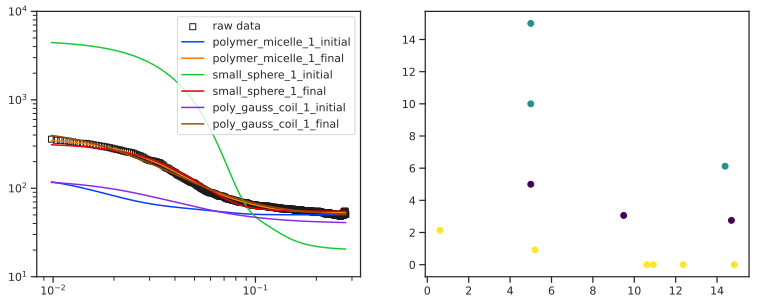


background 30.487481118250184
radius_core 38.96323607846493
rg 19.21696679600349
scale 1686.6316390353818
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 38.30775991307437
radius 32.5764987915297
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 16.90550598354802
sld 5.45
sld_solvent 6.36
background 29.157128932746446
i_zero 1986.821961916585
rg 145.2814786776962


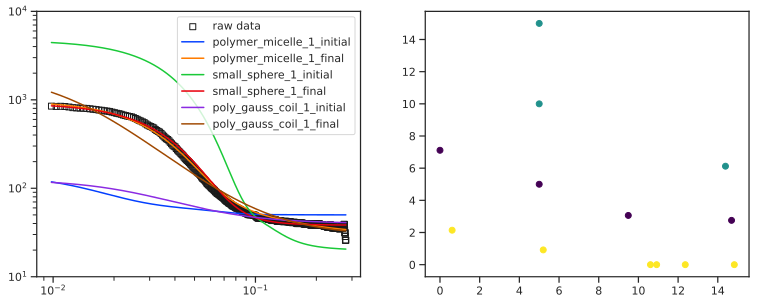


background 52.073308919129104
radius_core 11.92450165137582
rg 16.756408034643183
scale 135.80177810903905
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 55.68198394590308
radius 16.270683831747146
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 9.473590004166576
sld 5.45
sld_solvent 6.36
background 51.347920904393746
i_zero 78.79693746195592
rg 34.635690317914765


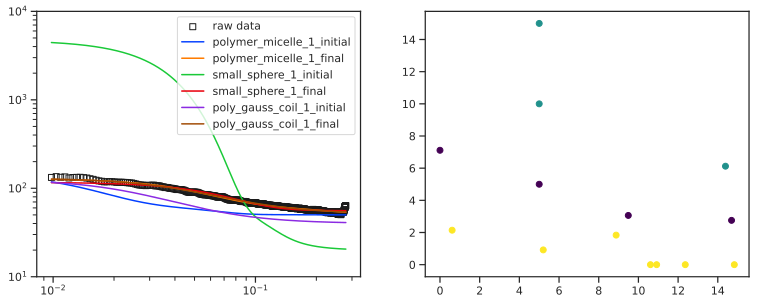


background 52.191407312771986
radius_core 11.698465887249682
rg 17.09648180878579
scale 138.47561560029084
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 56.06235571361492
radius 16.33787446266851
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 9.450275998889316
sld 5.45
sld_solvent 6.36
background 51.593718844240115
i_zero 78.9891482243826
rg 34.31584196633256


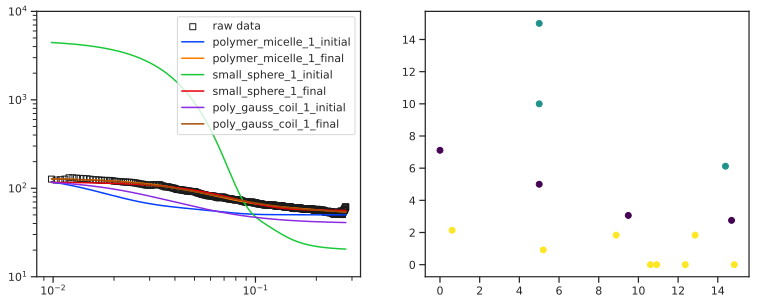


background 53.07946689135871
radius_core 19.076446549659696
rg 25.8151300723064
scale 295.9320083405349
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 56.64442189083308
radius 25.00362653335682
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 5.944786029257371
sld 5.45
sld_solvent 6.36
background 51.521348000528754
i_zero 191.55607590019298
rg 60.49363756719566


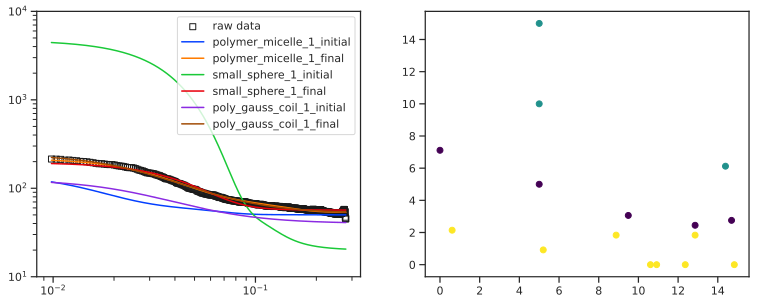


background 52.389200768947184
radius_core 10.913264202267772
rg 17.45382763479099
scale 136.73847623388178
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 56.76041461956472
radius 16.04317419106131
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 9.588726447352732
sld 5.45
sld_solvent 6.36
background 52.318545341517364
i_zero 75.97108444023876
rg 33.48199575621071


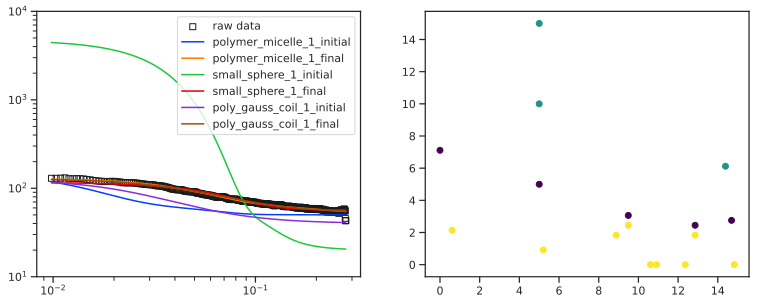


background 51.874721979129035
radius_core 13.238047888256794
rg 21.79673094726368
scale 175.53148125377967
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 56.06407652486192
radius 19.006448762389827
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 7.300695086501223
sld 5.45
sld_solvent 6.36
background 51.757202221451216
i_zero 98.84306106798046
rg 42.138957470773256


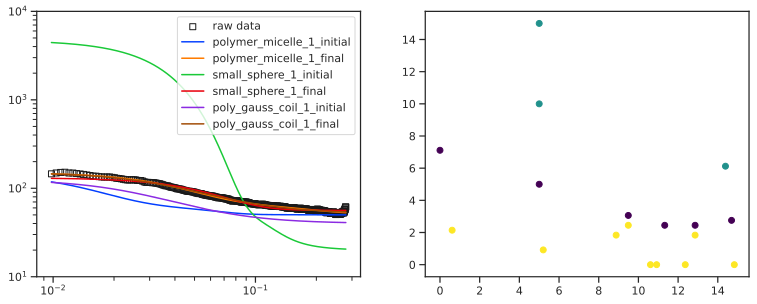


background 51.276676142355946
radius_core 11.190170530772109
rg 17.258271240652924
scale 133.21470537752015
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 55.295684012669135
radius 16.03444495632231
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 9.428387864621788
sld 5.45
sld_solvent 6.36
background 50.94882138787895
i_zero 74.5938244105117
rg 33.50596907307472


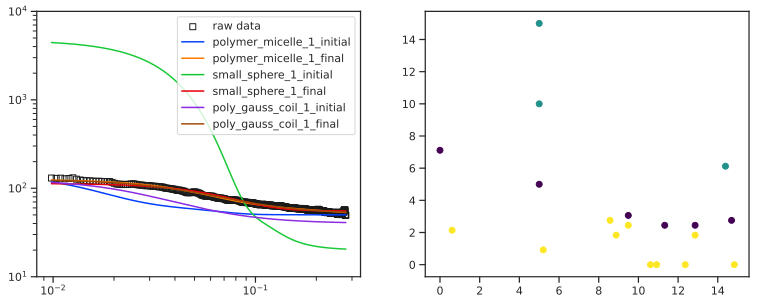


background 53.40735738483638
radius_core 16.19273285932978
rg 23.768122268472517
scale 238.04329041256875
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 57.09424598858106
radius 21.357825198741157
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 7.154981758123166
sld 5.45
sld_solvent 6.36
background 52.17984118673338
i_zero 141.07973540635462
rg 49.563284415762666


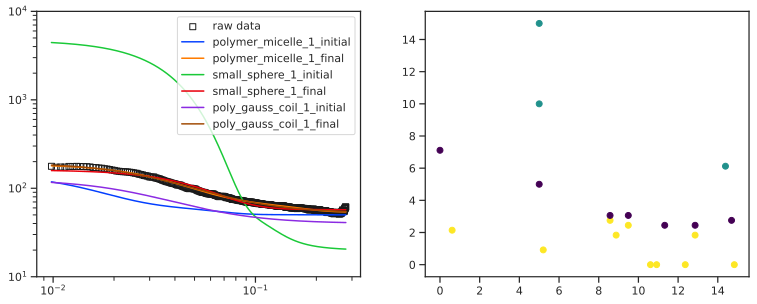


background 45.283379462286426
radius_core 36.83611370415352
rg 18.247085806452933
scale 923.1587968495778
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 50.06106370758179
radius 31.152681846922583
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 10.217377679238597
sld 5.45
sld_solvent 6.36
background 42.03933430115849
i_zero 800.4882918702198
rg 102.45833086203986


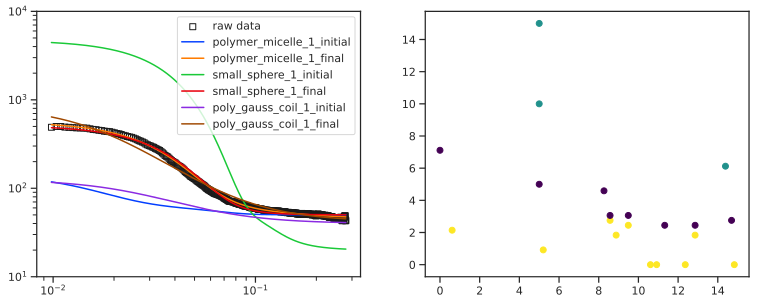


background 37.26629810335354
radius_core 38.50040851048387
rg 17.491482861659147
scale 1315.8419703006864
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 44.328846571346425
radius 31.749531644798896
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 13.90228028758985
sld 5.45
sld_solvent 6.36
background 35.251380957118386
i_zero 1295.986195743509
rg 119.5952786518107


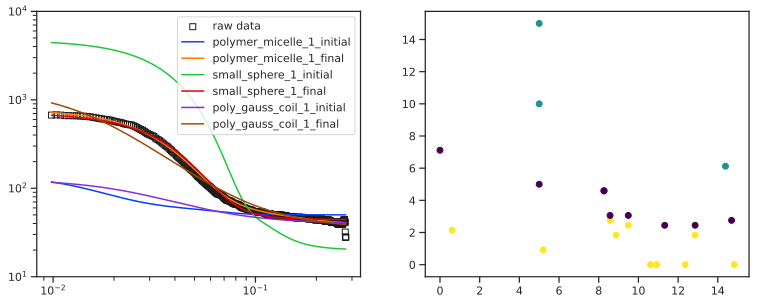


background 53.74221624813465
radius_core 11.954667425407404
rg 17.133894364134928
scale 132.58658076407798
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 57.16612115595862
radius 16.17149691493602
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 9.264023418420644
sld 5.45
sld_solvent 6.36
background 52.92030928131361
i_zero 75.58435052496452
rg 34.22959990444946


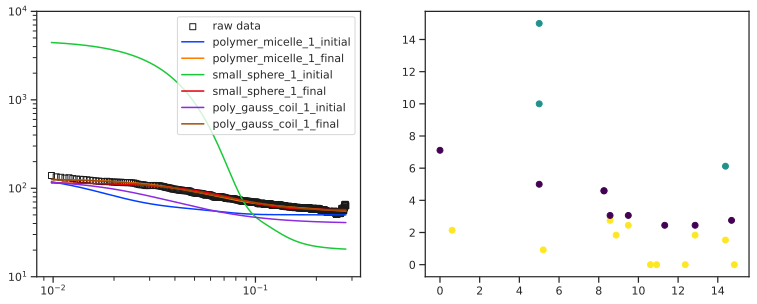


background 51.26205344747575
radius_core 25.111451747161393
rg 25.023131587111358
scale 443.40217721195694
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 53.999492361151994
radius 27.002188295922203
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 7.0394522109113655
sld 5.45
sld_solvent 6.36
background 47.964301727251325
i_zero 306.30010640131223
rg 71.585824647261


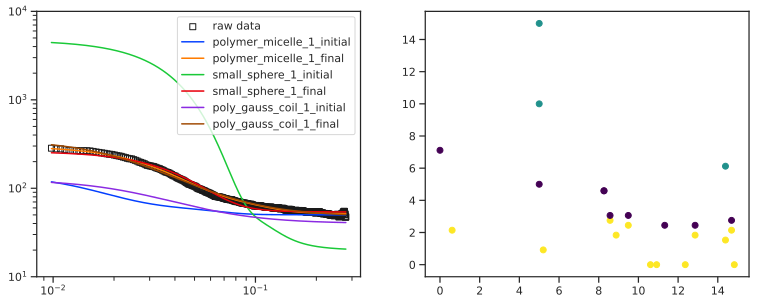


background 48.27925368982369
radius_core 30.74869013676251
rg 22.71906732684441
scale 614.8507453079968
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 51.0563432617094
radius 29.161166370234493
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 7.942087960371736
sld 5.45
sld_solvent 6.36
background 44.31923598040059
i_zero 468.2714198906175
rg 85.13197782725862


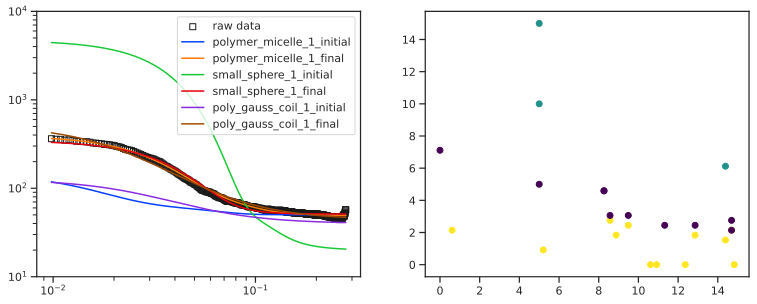


background 51.25561448459373
radius_core 21.5898850744545
rg 26.221723050459108
scale 361.7847626434219
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 54.42564115270216
radius 25.87221922909375
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 6.461362328808703
sld 5.45
sld_solvent 6.36
background 48.961514150788084
i_zero 243.84566918684658
rg 66.38073509721984


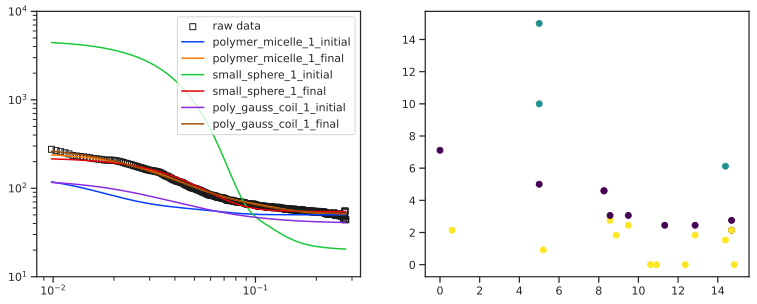


background 51.809880012057725
radius_core 26.75364190680914
rg 24.339937582626014
scale 478.303359809947
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 54.429684642789965
radius 27.592512625580387
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 7.164692779349944
sld 5.45
sld_solvent 6.36
background 48.22589579123431
i_zero 337.5433963385288
rg 74.62331418517036


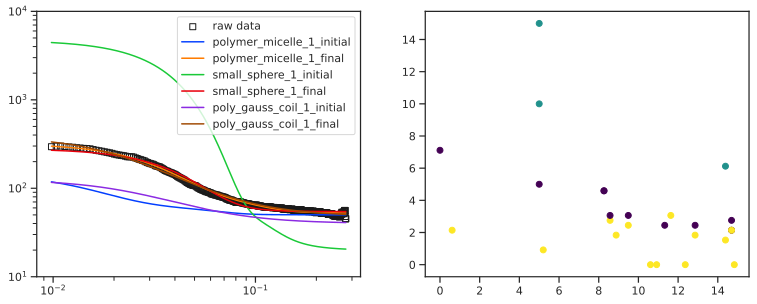


background 51.60294789052978
radius_core 24.18571632795692
rg 25.640317408491054
scale 411.3343056660643
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 54.372911721111585
radius 26.73716452207181
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 6.666835996664844
sld 5.45
sld_solvent 6.36
background 48.638403288272514
i_zero 282.14413763258455
rg 70.44894942640347


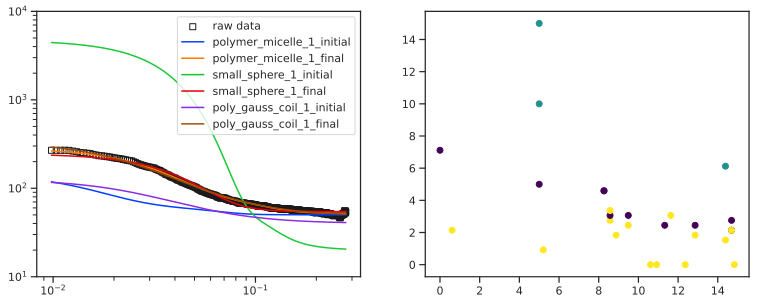


background 49.958865107083135
radius_core 15.138316289524772
rg 25.402868715790195
scale 209.53071674044978
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 54.11805010980735
radius 22.300866617233062
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 5.550383850774938
sld 5.45
sld_solvent 6.36
background 49.94329301100965
i_zero 124.93147741706619
rg 51.855514271186614


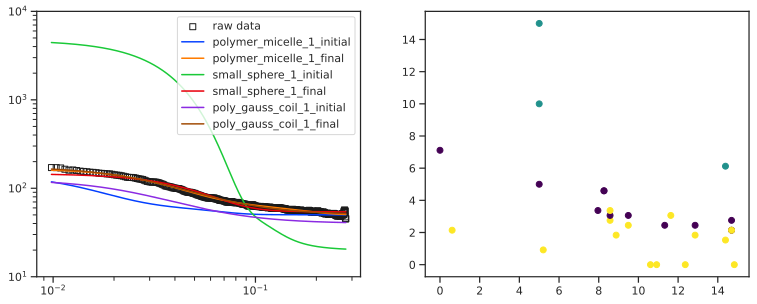


background 50.97290960909581
radius_core 18.572144447942755
rg 24.798819400848785
scale 286.85486011477053
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 54.31947652349344
radius 23.350068561715062
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 6.800299305552758
sld 5.45
sld_solvent 6.36
background 49.172425340368584
i_zero 180.40547445209373
rg 56.66161075220182


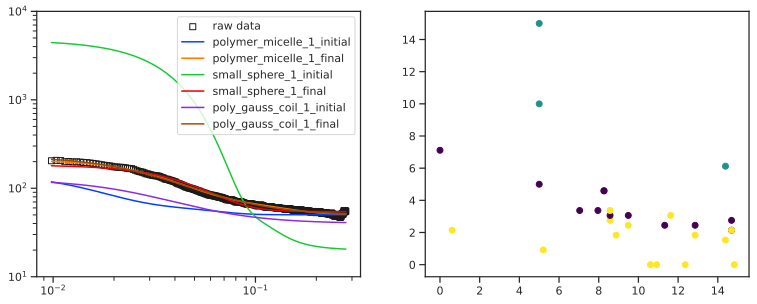


background 50.707179666062494
radius_core 11.082995732527706
rg 17.93345651599384
scale 132.10546750011602
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 54.73838815910733
radius 16.041289304682955
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 9.117467002444707
sld 5.45
sld_solvent 6.36
background 50.48537805502382
i_zero 72.24553739610654
rg 33.3948158217097


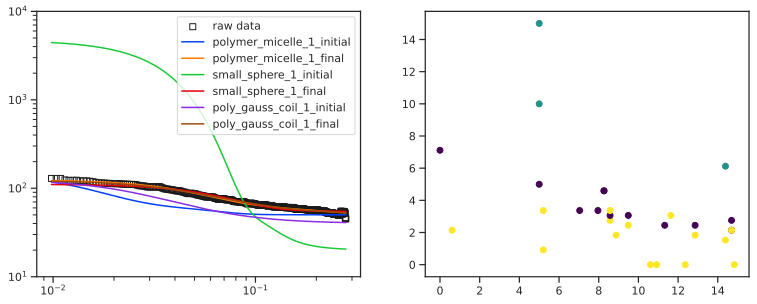


background 52.12053924193707
radius_core 16.732478955807764
rg 25.909504570941454
scale 271.2199841098725
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 56.477690200067244
radius 23.7156759720861
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 6.204623520285174
sld 5.45
sld_solvent 6.36
background 51.550472409625065
i_zero 172.66542383601825
rg 57.281180653073974


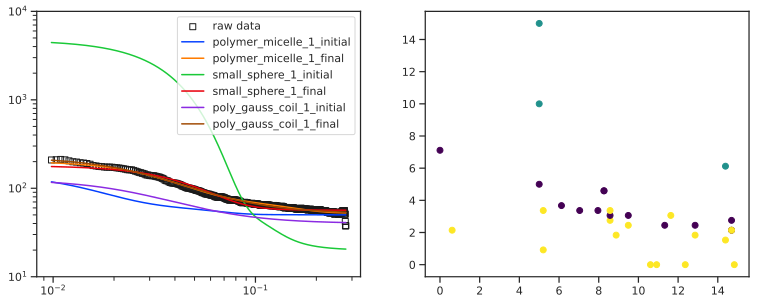


background 51.192578341029225
radius_core 24.64016602116631
rg 24.60238971576397
scale 478.8089338109019
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
background 54.17745506730765
radius 26.49188945090081
radius_pd 0.5
radius_pd_n 15
radius_pd_type gaussian
scale 8.038478693590198
sld 5.45
sld_solvent 6.36
background 47.617906177674264
i_zero 331.86407895207213
rg 70.48606535522126


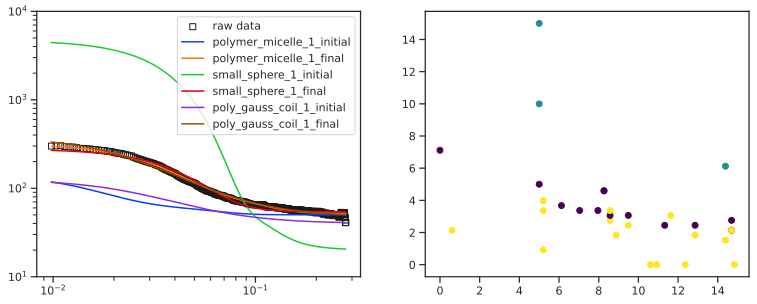

In [294]:
def label_items(arr):
    return np.unique(arr, return_inverse=True)
def label_key(arr):
    return np.unique(arr)

best_fits = []
chisqs = []
X = []
for idx in range(33):
    
    fit_method={'method':'lm',
                'steps':10000,
                'ftol': 1.5e-6,
                'xtol': 1.5e-6,
                'verbose':True
               }
    
    fit_method= report_json['fit_method']
    print()
    model_starts = report_json['model_inputs']
    fit_results = report_json['best_fits']['model_idx'][idx]
    empty_data = sasmodels.data.empty_data1D(np.logspace(np.log10(model_ds.q.values.min()),
                                                         np.log10(model_ds.q.values.max()),
                                                         1000
                                                        ))
    # bf = report_json['best_fits'][f'data_{str(idx+1).zfill(3)}']
    # best_fits.append(bf['model_name'])
    # chisqs.append(bf['lowest_chisq'])
    # best_fits.append(report_json['best_fits'][idx])
    best_fits.append(fit_results)
    X.append([model_ds.benzyl_alcohol_solute.values[idx],model_ds.phenol_solute.values[idx]])
    
    
    fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
    ax[0].scatter(q,model_ds.SAS[idx].values,label='raw data',color='k',marker='s',facecolors='none')
    for mdx in range(len(model_starts)):
        init_model = model_starts[mdx]
        fit_model = report_json['model_fits'][idx][mdx]
        # print(init_model)
        # print(fit_model)
        # print()
        init_model = sas_wrapper(
            name=init_model['name'],
            sasmodel_type=init_model['sasmodel'],
            parameters=init_model['fit_params'],
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
            )
        
        #fit model parameters are not the same format as the initialized model. rebuild an unbounded parameters
        #dictionary this way
        
        params_final = {}
        for key in list(fit_model['output_fit_params']):
            print(key, fit_model['output_fit_params'][key]['value'])
            params_final[key] = {'value':fit_model['output_fit_params'][key]['value'], 'bounds':None}
        fit_model = sas_wrapper(
            name=fit_model['name'],
            sasmodel_type=fit_model['sasmodel'],
            parameters=params_final,
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
            )
        
        
        ax[0].plot(init_model.model_q, init_model.model_I, label=f'{init_model.name}_initial')
        ax[0].plot(fit_model.model_q, fit_model.model_I, label=f'{fit_model.name}_final')
        ax[0].set(
            xscale='log',
            yscale='log',
            ylim= (1e1,1e4)
            )
        ax[0].legend()
    _, clss = label_items(best_fits)
    key = label_key(best_fits)
    ax[1].scatter(np.array(X)[:,0],np.array(X)[:,1],c=clss,cmap='viridis')
    plt.show(fig)
    plt.close(fig)

## test startup and base functions